# Predição de aprovação de empréstimos

## Uma empresa de crédito precisa de uma forma de avaliar o pedido de empréstimo de seus clientes de forma automatizada. Para isso, esta resolve recorrer a um algoritmo de classificação que seja capaz de aprovar ou não o pedido, baseando-se em dados fornecidos pelo cliente através de um form online.

## Os dados podem ser obtidos no link: https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/ . Obs: O site exige que você se registre para ter acesso aos dados.

### As variaveis que são colhidas do aplicante a empréstimo são(inglês):

* Loan_ID - Loan ID

* Gender  - Male/ Female

* Married - Applicant married (Y/N)

* Dependents - Number of dependents

* Education - Applicant Education (Graduate/ Under Graduate)

* Self_Employed - Self employed (Y/N)

* ApplicantIncome - Applicant income

* CoapplicantIncome - Coapplicant income

* LoanAmount - Loan amount in thousands

* Loan_Amount_Term - Term of loan in months

* Credit_History - credit history meets guidelines

* Property_Area - Urban/ Semi Urban/ Rural

### A variavel que tentaremos classificar é:
* Loan_Status - Loan approved (Y/N)

# Inicio da análise

### Importando as bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

### Carregando os dados

In [2]:
train_data = pd.read_csv("train.csv")
test_data  = pd.read_csv("test.csv")

### Como os nomes ja indicam, treinaremos o modelo a partir do train.csv e validaremos no conjunto test.csv. Agora vamos inspecionar o conjunto de treinamento

In [3]:
#primeiras 5 linhas do conjunto de dados
train_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
#informacoes gerais sobre cada coluna
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB


In [5]:
#dimensao do conjunto de dados
train_data.shape

(614, 13)

In [6]:
#contagem dos valores nulos em cada coluna
train_data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

### Com essas observaçoes iniciais podemos observar que 7 colunas possuem valores NaN, em especial as colunas Credit_History e Self_Employed. Antes de lidar com esses valores faltantes vamos explorar um pouco o conjunto de dados para que possamos ganhar mais informações sobre o problema que temos em mãos

### Para isso vamos gerar estatisticas descritivas e diversos gráficos

In [7]:
train_data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


### Gráfico de correlação entre as variaveis numericas

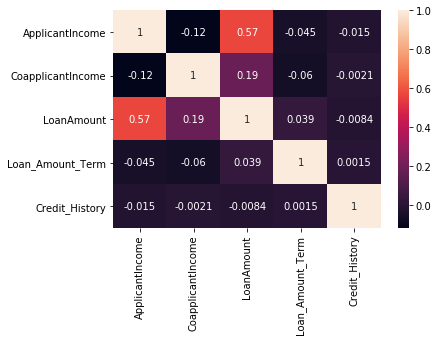

In [8]:
numeric_variables = train_data[['ApplicantIncome', 'CoapplicantIncome','LoanAmount','Loan_Amount_Term', 'Credit_History']]
corr = numeric_variables.corr()
sns.heatmap(corr, annot=True)

### Podemos verificar que a correlação é muito baixa entre todas as variaveis numéricas. Agora vamos explorar as variaveis categoricas

### Analise da variavel alvo, será que ela está desbalanceada?

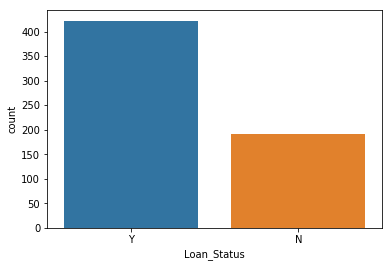

In [9]:
sns.countplot(x='Loan_Status', data=train_data)

### Como podemos observar há um desbalanceamento, mas este não é critico e provavelmente nao precisaremos de tecnicas de amostragem como Under Sampling, Over Sampling etc

### Analise do Gênero: Será que o gênero influencia na aprovação do crédito?

In [10]:
train_data.groupby(['Gender', 'Loan_Status'])['Loan_ID'].count()

Gender  Loan_Status
Female  N               37
        Y               75
Male    N              150
        Y              339
Name: Loan_ID, dtype: int64

### Proporcionalmente, homens tendem a ter mais aprovação de crédito. Obviamente essa análise não leva em consideração outros fatores, mas nos dá uma noção da distribuição dos dados

### Analise do Grau de Instrução: Será que temos mais aprovação(proporcionalmente) para quem possui ensino superior?

In [11]:
train_data.groupby(['Education', 'Loan_Status'])['Loan_ID'].count()

Education     Loan_Status
Graduate      N              140
              Y              340
Not Graduate  N               52
              Y               82
Name: Loan_ID, dtype: int64

### Proporcionalmente, pessoas graduadas tendem a ter mais aprovação de crédito. Novamente, essa análise não leva em consideração outros fatores.

### Analise do Estado Civil: Será que temos mais aprovação(proporcionalmente) para quem é casado?

In [12]:
train_data.groupby(['Married', 'Loan_Status'])['Loan_ID'].count()

Married  Loan_Status
No       N               79
         Y              134
Yes      N              113
         Y              285
Name: Loan_ID, dtype: int64

### Proporcionalmente, pessoas casadas tendem a ter mais aprovação de crédito, porém, a diferença na proporção é baixa. Novamente, essa análise não leva em consideração outros fatores.

### Para não alongar muito a análise, a partir daqui vamos limpar os dados para então treinar nosso modelo de classificação.

### Primeiro vamos lidar com os valores faltantes(NaN) de cada coluna. A estrategia usada foi: Eliminar as linhas com poucos valores NaN e preencher com a moda as colunas que tinham mais valores NaN.

In [13]:
train_data['Gender'].fillna(train_data['Gender'].mode()[0], inplace= True)
train_data['Dependents'].fillna(train_data['Dependents'].mode()[0], inplace= True)
train_data['Credit_History'].fillna(train_data['Credit_History'].mode()[0], inplace= True)
train_data['Self_Employed'].fillna(train_data['Self_Employed'].mode()[0], inplace= True)
train_data = train_data.dropna(axis=0)

In [14]:
train_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y


### Agora vamos tornar as variaveis categoricas em numeros para que possamos treinar os algoritmos.

In [15]:
train_data = train_data.drop('Loan_ID', axis=1)
train_data = pd.get_dummies(train_data, drop_first=True)

### Agora separamos a variavel alvo das demais.

In [16]:
X = train_data.drop('Loan_Status_Y', axis = 1)
y = train_data['Loan_Status_Y']

### Separando o conjunto de treinamento e reservando uma parte deste para testar o modelo

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

### Normalizando o conjunto de dados para que possamos convergir mais rapidamente e eliminar a diferença de dimensão das variaveis.

In [18]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Agora testaremos um modelo simples e depois veremos o desempenho de varios algoritmos para decidir o melhor

In [19]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Utilizaremos o modelo para predizer os valores do conjunto de teste

In [20]:
y_pred = model.predict(X_test)

### Fazendo a matriz de confusão para avaliar o modelo base temos:

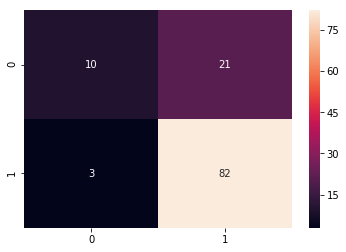

In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot= True)

### Esse modelo teve 79% de acerto, o que não é ruim mas está longe do ideal. Testaremos agora diversos algoritmos para tentar achar algum que performe melhor que nosso modelo base

LR: 0.817557 (0.031322)
LDA: 0.817651 (0.033811)
KNN: 0.763100 (0.040533)
CART: 0.684850 (0.052604)
NB: 0.800350 (0.036279)
SVM: 0.813255 (0.032565)
XGboost: 0.800300 (0.036978)
MLP: 0.772359 (0.060598)


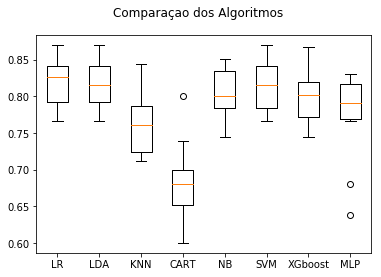

In [22]:
#importando modelos do Scikit-Learn
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Preparando modelos
models = []
models.append(('LR', LogisticRegression(random_state=0)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=0)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=0)))
models.append(('XGboost', XGBClassifier(random_state=0)))
models.append(('MLP', MLPClassifier(hidden_layer_sizes=(24, 16, 4), max_iter = 400, random_state=0)))
# Avaliar cada modelo por vez
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=10, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# Box plot da para comparar os algoritmos
fig = plt.figure()
fig.suptitle('Comparaçao dos Algoritmos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Após teste de varios algoritmos chegamos a conclusão de que o nosso modelo base de Regressão Logística já é o melhor modelo possível dentre os testados. Agora iremos predizer o conjunto de testes e enviar a saida para o site.

In [23]:
test_data.isnull().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

### Como observado acima, o conjunto de validação fornecido pelo site possui valores faltantes. Se faz necessário então limpar estes valores para realizarmos a predição do nosso modelo.

In [24]:
test_data['Gender'].fillna(test_data['Gender'].mode()[0], inplace= True)
test_data['Dependents'].fillna(test_data['Dependents'].mode()[0], inplace= True)
test_data['Self_Employed'].fillna(test_data['Self_Employed'].mode()[0], inplace= True)
test_data['LoanAmount'].fillna(test_data['LoanAmount'].mean(), inplace=True)
test_data['Loan_Amount_Term'].fillna(test_data['Loan_Amount_Term'].mean(), inplace=True)
test_data['Credit_History'].fillna(test_data['Credit_History'].mode()[0], inplace= True)

### Agora prepararemos os dados para envio no site que avaliará internamente nosso modelo.

In [25]:
#Treinando o melhor modelo(RegLog)
model = LogisticRegression()
model.fit(X_train, y_train)

#Guardando o ID das prediçoes para enviar na submissao ao site
Loan_ID = test_data['Loan_ID']

#Excluindo a coluna ID para realizar a prediçao com o modelo
test_data = test_data.drop('Loan_ID', axis = 1)

#Prevendo os dados de validaçao
test_data = pd.get_dummies(test_data, drop_first= True)

y_pred = model.predict(test_data).astype(int)

#Gerando o arquivo de submissao
Submission = pd.DataFrame({ 'Loan_ID': Loan_ID,
                            'Loan_Status': y_pred })
Submission["Loan_Status"] = np.where(Submission.Loan_Status ==1,"Y","N")
Submission.to_csv("Submission.csv", index=False)